In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.display import display
import radiant

In [2]:
df_train_full = pd.read_csv("playground-series-s4e10/train.csv")
df_test = pd.read_csv("playground-series-s4e10/test.csv")

In [3]:
df_train_full.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
df_test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


## Data preparation and data cleaning

In [5]:
df_train_full.isnull().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [6]:
df_train_full.columns = df_train_full.columns.str.lower().str.replace(" ", "_")
df_test.columns = df_test.columns.str.lower().str.replace(" ", "_")

In [7]:
df_train_full.dtypes

id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

In [9]:
df_train_full['person_emp_length'] = df_train_full['person_emp_length'].astype('int')
df_test['person_emp_length'] = df_test['person_emp_length'].astype('int')

In [10]:
categorical_col = df_train_full.select_dtypes(include='object').columns.to_list()
numerical_col = df_train_full.columns.difference(categorical_col + ['loan_status'] + ['id']).to_list()

## EDA

### Check if the target value is imbalance

loan_status
0    0.857618
1    0.142382
Name: proportion, dtype: float64


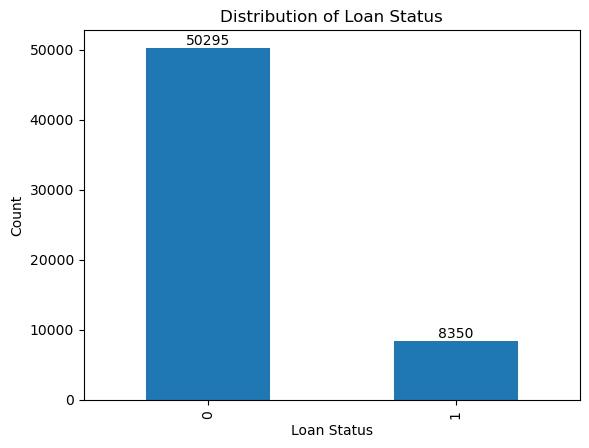

In [11]:
print(df_train_full['loan_status'].value_counts(normalize = True))
df_train_full['loan_status'].value_counts().plot(kind='bar')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Distribution of Loan Status')
for i, v in enumerate(df_train_full['loan_status'].value_counts()):
    plt.text(i, v + 0.05, str(v), ha='center', va='bottom')
plt.show()

### Check extreme values

In [12]:
display(df_train_full[numerical_col].describe())

,cb_person_cred_hist_length,loan_amnt,loan_int_rate,loan_percent_income,person_age,person_emp_length,person_income
count,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,5.864500e+04
mean,5.813556,9217.556518,10.677874,0.159238,27.550857,4.701015,6.404617e+04
std,4.029196,5563.807384,3.034697,0.091692,6.033216,3.959784,3.793111e+04
min,2.000000,500.000000,5.420000,0.000000,20.000000,0.000000,4.200000e+03
25%,3.000000,5000.000000,7.880000,0.090000,23.000000,2.000000,4.200000e+04
50%,4.000000,8000.000000,10.750000,0.140000,26.000000,4.000000,5.800000e+04
75%,8.000000,12000.000000,12.990000,0.210000,30.000000,7.000000,7.560000e+04
max,30.000000,35000.000000,23.220000,0.830000,123.000000,123.000000,1.900000e+06


In [13]:
print("Age over 123 years old")
display(df_train_full[df_train_full['person_age'] > 122])
print("Age less than Employement Length")
display(df_train_full[df_train_full.person_age <= df_train_full.person_emp_length])
print("Credit History over Age")
display(df_train_full[df_train_full.cb_person_cred_hist_length >= df_train_full.person_age])

Age over 123 years old


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
47336,47336,123,36000,MORTGAGE,7,PERSONAL,B,6700,10.75,0.18,N,4,0


Age less than Employement Length


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
41079,41079,28,60350,MORTGAGE,123,MEDICAL,D,25000,15.95,0.35,Y,6,1
49252,49252,21,192000,MORTGAGE,123,VENTURE,B,20000,11.49,0.10,N,2,0


Credit History over Age


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
21827,21827,28,186480,MORTGAGE,2,PERSONAL,A,10000,5.42,0.05,N,29,0


In [14]:
df_train_full = df_train_full[(df_train_full['person_age'] <= 122) & 
                              (df_train_full['person_age'] > df_train_full['person_emp_length']) &
                              (df_train_full['cb_person_cred_hist_length'] < df_train_full['person_age'])]

### Check numerical features distribution

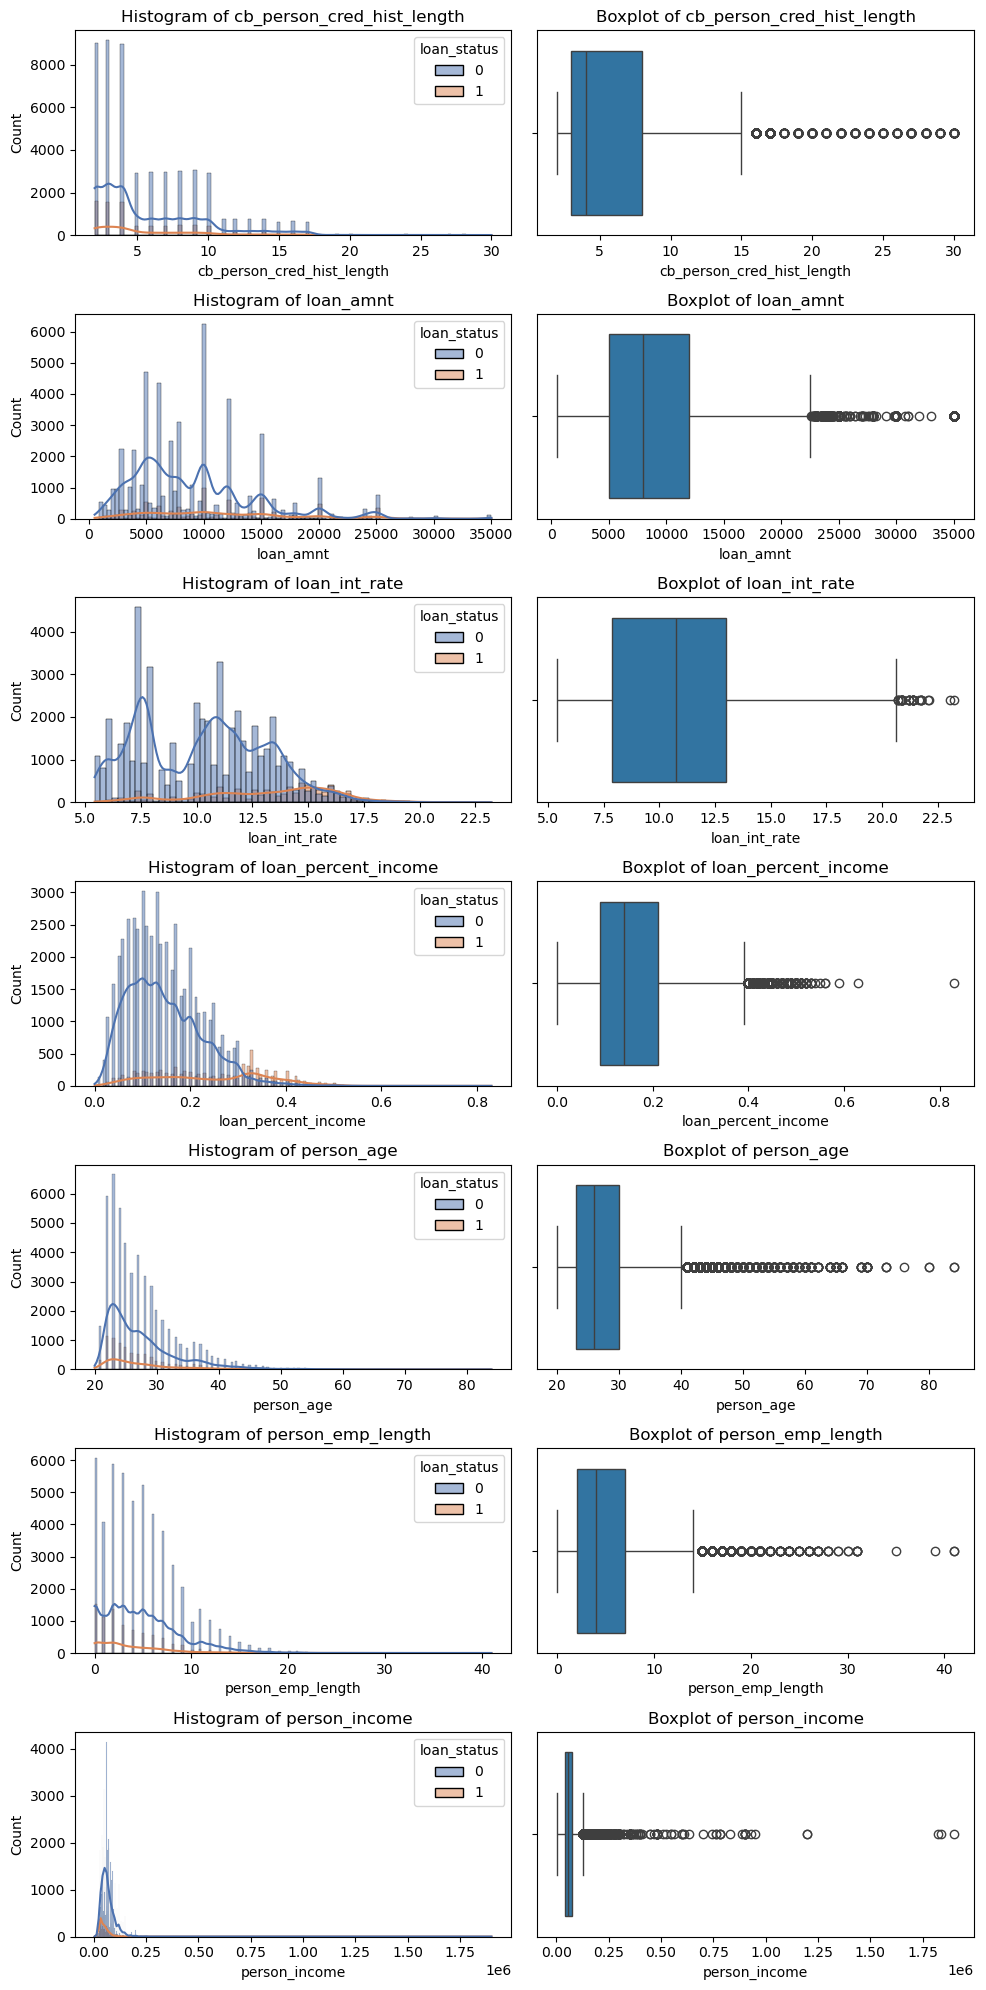

In [15]:
fig, axes = plt.subplots(len(numerical_col), 2, figsize=(10, 20))
axes = axes.flatten()
for i, col in enumerate(numerical_col):
    sns.histplot(data=df_train_full, x=col, kde=True, ax=axes[i * 2], hue=df_train_full.loan_status, palette = 'deep')
    axes[i * 2].set_title(f'Histogram of {col}')
    
    sns.boxplot(x=df_train_full[col], ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

### Check categorical variables

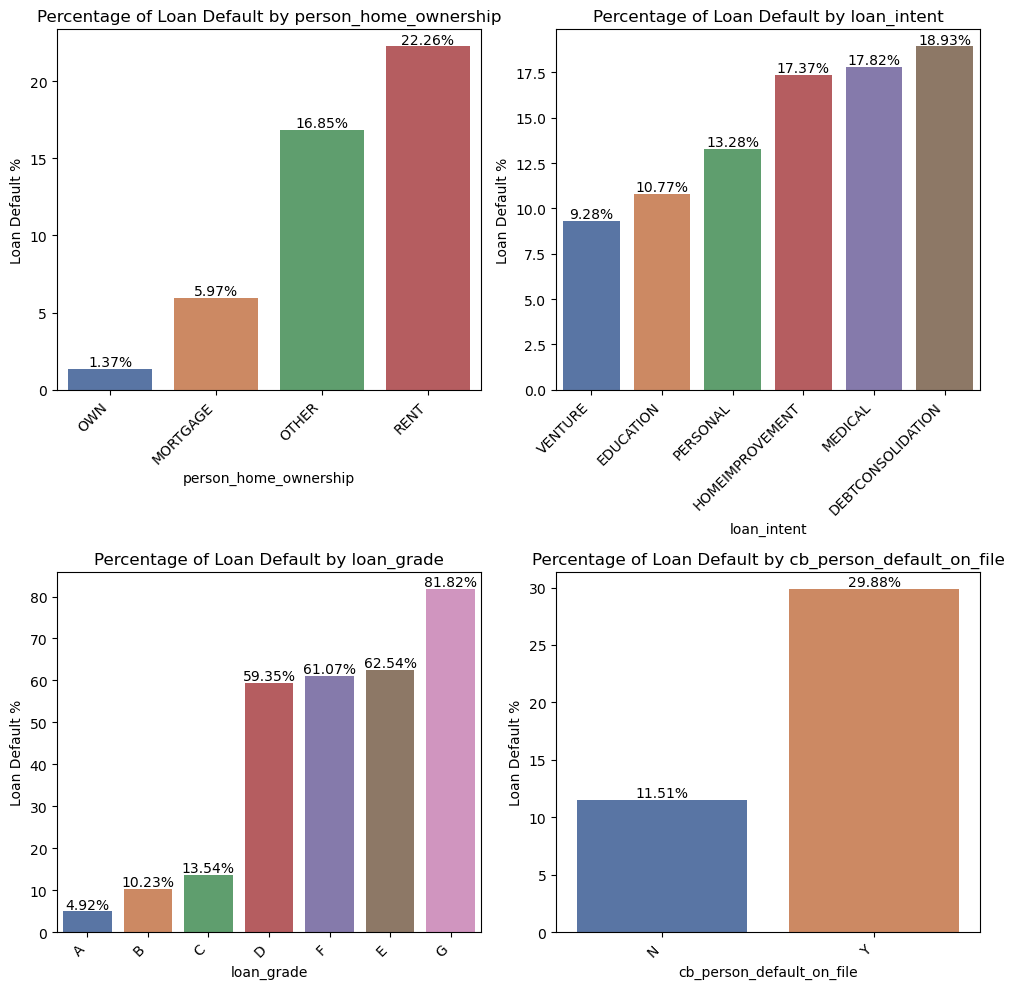

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_col):
    # calculating the percentage of positive target variable for each category
    percentage_df = df_train_full.groupby(col)['loan_status'].mean().sort_values().reset_index()
    percentage_df['loan_status'] = percentage_df['loan_status'] * 100

    # Create the barplot
    sns.barplot(data=percentage_df, x=col, y='loan_status', ax=axes[i], hue=col, palette='deep', legend=False)
    
    # Set title and labels
    axes[i].set_title(f'Percentage of Loan Default by {col}')
    axes[i].set_xticks(axes[i].get_xticks())
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].set_ylabel('Loan Default %')

    # Display the y-values (loan default percentages) on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height():.2f}%', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         fontsize=10, color='black', 
                         xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

## Feature Engineering

In [20]:
def add_features(df):
    df2=df.copy()
    
    df2['total_amount_payable'] = np.floor(df2['loan_amnt'] * (1+df2['loan_int_rate']/100))
    df2['interest'] = np.floor(df2['loan_amnt'] * df2['loan_int_rate']/100)
    df2['credit_hist_ vs_age'] = np.round(df2['cb_person_cred_hist_length'] / df2['person_age'], 2)
    df2['credit_hist_vs_work'] = np.round(df2['person_emp_length']/df2['cb_person_cred_hist_length'], 2)
    df2['risk_flag'] = np.where((df2['cb_person_default_on_file'] == 'Y') & (df2['loan_grade'].isin(['D', 'E', 'F', 'G'])), 1, 0)

    return df2

add_features(df_train_full)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,total_amount_payable,interest,credit_hist_ vs_age,credit_hist_vs_work,risk_flag
0,0,37,35000,RENT,0,EDUCATION,B,6000,11.49,0.17,N,14,0,6689.0,689.0,0.38,0.00,0
1,1,22,56000,OWN,6,MEDICAL,C,4000,13.35,0.07,N,2,0,4534.0,534.0,0.09,3.00,0
2,2,29,28800,OWN,8,PERSONAL,A,6000,8.90,0.21,N,10,0,6534.0,534.0,0.34,0.80,0
3,3,30,70000,RENT,14,VENTURE,B,12000,11.11,0.17,N,5,0,13333.0,1333.0,0.17,2.80,0
4,4,22,60000,RENT,2,MEDICAL,A,6000,6.92,0.10,N,3,0,6415.0,415.0,0.14,0.67,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5,EDUCATION,D,25000,15.95,0.21,Y,10,0,28987.0,3987.0,0.29,0.50,1
58641,58641,28,28800,RENT,0,MEDICAL,C,10000,12.73,0.35,N,8,1,11273.0,1273.0,0.29,0.00,0
58642,58642,23,44000,RENT,7,EDUCATION,D,6800,16.00,0.15,N,2,1,7887.0,1088.0,0.09,3.50,0
58643,58643,22,30000,RENT,2,EDUCATION,A,5000,8.90,0.17,N,3,0,5445.0,445.0,0.14,0.67,0


In [21]:
df_train_full = add_features(df_train_full)

## Split the dataset

In [23]:
def split_data(df, test_size, random_state):
    df = df_train_full.copy()
    
    df_train, df_val = train_test_split(df, test_size = test_size, random_state = random_state)
    
    y_train = df_train.loan_status.values
    y_val = df_val.loan_status.values

    df_train = df_train.drop(columns=['loan_status', 'id']).reset_index(drop = True)
    df_val = df_val.drop(columns=['loan_status', 'id']).reset_index(drop = True)

    return df_train, df_val, y_train, y_val

df_train, df_val, y_train, y_val = split_data(df_train_full, 0.25, 1)

## Model selection

In [24]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import time

train_dicts = df_train.to_dict(orient = 'records')
val_dicts = df_val.to_dict(orient = 'records')

dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

### Decision Tree Model

In [25]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

start_time = time.time()
dt.fit(X_train, y_train)
end_time = time.time()

y_pred_dt = dt.predict(X_val)
roc_auc_dt = roc_auc_score(y_pred_dt, y_val)
print(f"Total Decision Tree Model Excution Time is: {(end_time-start_time):.3f} seconds")
print(f"For Decision Tree Model, ROC AUC on validation set: {roc_auc_dt:.3f}")

Total Decision Tree Model Excution Time is: 0.389 seconds
For Decision Tree Model, ROC AUC on validation set: 0.812


### Random Forest Model

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300],  
    'max_depth': [None, 10, 20, 30],      
    'min_samples_split': [2, 5, 10],  
}

rf = RandomForestClassifier(random_state=1, n_jobs=-1)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, cv=5, scoring='roc_auc')

start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

print(f"Best parameters: {random_search.best_params_}")
print(f"Best ROC AUC score: {random_search.best_score_}")

y_pred_rf = random_search.best_estimator_.predict_proba(X_val)[:, 1]
roc_auc_rf = roc_auc_score(y_val, y_pred_rf)
print(" ")
print(f"Total RandomizedSearchCV execution time: {end_time - start_time:.2f} seconds")
print(f"For Random Forest Model, ROC AUC on validation set:{roc_auc_rf:.3f}")

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20}
Best ROC AUC score: 0.9329814561792332
 
Total RandomizedSearchCV execution time: 55.47 seconds
For Random Forest Model, ROC AUC on validation set:0.932


### XGBoost

In [27]:
value_counts = df_train_full['loan_status'].value_counts()
value_counts[0] / value_counts[1]
### scale_pos_weight choose 6

6.023715415019763

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

param_dist = {
    'max_depth': randint(3, 10),  
    'eta': uniform(0.01, 0.3),  
    'min_child_weight': randint(1, 10), 
    'subsample': uniform(0.7, 0.3),  
    'colsample_bytree': uniform(0.7, 0.3), 
    'n_estimators': randint(50, 300),
    'scale_pos_weight': [6],  
    'gamma': uniform(0, 1),  
}

xgb_model = XGBClassifier(objective='binary:logistic', seed=1)


random_search = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_dist, 
    n_iter=50, 
    scoring='roc_auc',  
    cv=5,  
    n_jobs=-1, 
    verbose=1, 
    random_state=1
)

start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

print(f"Best parameters: {random_search.best_params_}")
print(f"Best ROC AUC score: {random_search.best_score_}")
y_pred_prob_xgb = random_search.best_estimator_.predict_proba(X_val)[:, 1]
roc_auc_xgb = roc_auc_score(y_val, y_pred_prob_xgb)
print(" ")
print(f"Total RandomizedSearchCV Execution Time: {(end_time - start_time):.3f} seconds")
print(f"ROC AUC on validation set: {roc_auc_xgb:.3f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 4201, number of negative: 25119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 29320, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143281 -> initscore=-1.788302
[LightGBM] [Info] Start training from score -1.788302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'colsample_bytree': 0.7796639978116678, 'eta': 0.15747194778410148, 'gamma': 0.053362545117080384, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 293, 'scale_pos_weight': 6, 'subsample': 0.9869606970011566}
Best ROC AUC score: 0.9526719143516805
 
Total RandomizedSearchCV Execution Time: 47.987 seconds
ROC AUC on validation set: 0.954


### Catboost

In [34]:
from catboost import CatBoostClassifier

param_dist = {
    'iterations': randint(50, 500),
    'depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'l2_leaf_reg': randint(1, 10),
    'border_count': randint(32, 255),
    'bagging_temperature': uniform(0, 5),
}


cat_model = CatBoostClassifier(cat_features=categorical_col, verbose=200, early_stopping_rounds=50)

random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=10,  
    scoring='roc_auc', 
    cv=3,  
    n_jobs=-1, 
    verbose=1,
    random_state=1
)

start_time = time.time()
random_search.fit(df_train, y_train)
end_time = time.time()

print(f"Best parameters: {random_search.best_params_}")
print(f"Best ROC AUC score: {random_search.best_score_}")
y_pred_cat = random_search.best_estimator_.predict(df_val)
roc_auc_cat = roc_auc_score(y_pred_cat, y_val)
print(" ")
print(f"Total Catboost Model Excution Time is: {(end_time-start_time):.3f} seconds")
print(f"For Catboost Model, ROC AUC on validation set: {roc_auc_cat:.3f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

### LightGBM

In [35]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for col in categorical_col:
    df_train[col] = encoder.fit_transform(df_train[col])

for col in categorical_col:
    df_val[col] = df_val[col].apply(lambda x: encoder.transform([x])[0] if x in encoder.classes_ else -1)

param_dist = {
    'num_leaves': randint(20, 150), 
    'learning_rate': uniform(0.01, 0.3), 
    'feature_fraction': uniform(0.6, 0.4), 
    'bagging_fraction': uniform(0.6, 0.4), 
    'max_depth': randint(3, 12),
    'min_data_in_leaf': randint(10, 100), 
    'lambda_l1': uniform(0, 1), 
    'lambda_l2': uniform(0, 1) 
}

lgb_model = lgb.LGBMClassifier(objective='binary', metric='auc', boosting_type='gbdt', random_state=1)

random_search = RandomizedSearchCV(
    estimator=lgb_model, 
    param_distributions=param_dist, 
    n_iter=30, 
    scoring='roc_auc', 
    cv=3, 
    n_jobs=-1,  
    verbose=1, 
    random_state=1
)

start_time = time.time()
random_search.fit(df_train, y_train)
end_time = time.time()

print(f"Best parameters: {random_search.best_params_}")
print(f"Best ROC AUC score: {random_search.best_score_}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [36]:
y_pred_lgb = random_search.best_estimator_.predict_proba(df_val)[:, 1]
roc_auc_lgb = roc_auc_score(y_val, y_pred_lgb)
print(" ")
print(f"Total RandomizedSearchCV Execution Time: {(end_time - start_time):.3f} seconds")
print(f"ROC AUC on validation set: {roc_auc_lgb:.3f}")

[LightGBM] [Warning] lambda_l1 is set=0.9494892587070712, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9494892587070712
[LightGBM] [Warning] feature_fraction is set=0.64589838918135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64589838918135
[LightGBM] [Warning] bagging_fraction is set=0.8486782880836488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8486782880836488
[LightGBM] [Warning] lambda_l2 is set=0.4499121334799405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4499121334799405
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
 
Total RandomizedSearchCV Execution Time: 28.262 seconds
ROC AUC on validation set: 0.916


In [37]:
roc_auc_results_df = {
    'Decision Tree': roc_auc_dt,  
    'Random Forest': roc_auc_rf, 
    'XGBoost': roc_auc_xgb, 
    'Catboost': roc_auc_cat, 
    'LightGBM': roc_auc_lgb  
}

roc_auc_results = pd.DataFrame(list(roc_auc_results_df.items()), columns=['Model', 'ROC_AUC'])
roc_auc_results.sort_values(by='ROC_AUC', ascending=False)

,Model,ROC_AUC
2,XGBoost,0.954153
1,Random Forest,0.932036
4,LightGBM,0.915620
0,Decision Tree,0.811641
3,Catboost,0.646036


[LightGBM] [Warning] bagging_fraction is set=0.757950245169422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.757950245169422
[LightGBM] [Warning] lambda_l2 is set=0.12632951943963733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12632951943963733
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Info] Number of positive: 4200, number of negative: 25120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 29320, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143247 -> initscore=-1.788580
[LightGBM] [Info] Start training from score -1.788580
[LightGBM] [Warning] No further splits w

## We choose XGoost Model with Best parameters: 
### 'colsample_bytree': 0.7796639978116678, 
### 'eta': 0.15747194778410148, 
### 'gamma': 0.053362545117080384, 
### 'max_depth': 4, 
### 'min_child_weight': 8, 
### 'n_estimators': 293, 
### 'scale_pos_weight': 6, 
### 'subsample': 0.9869606970011566

In [ ]:
df_train